## **Education Statistics - Budget Forecasting**

### *Author: Marzieh Safari*

### Source for data:
<a href="https://nces.ed.gov/ipeds/datacenter/InstitutionList.aspx?goToReportId=1&sid=17f4a5f0-2e59-45c3-91c3-51c5674f4ccf&rtid=1"> 
IPEDS - NCES </a>

### **Objectives:**
#### 1. Forecasting total expenses for Public University *i.e.* Central Ohio Technical College (COTC)
#### 2. Indication of factors influencing total expenses

### **Executive Summary of Forecast Methodology and Results:**

*To project institutional expenses for the 2025–2027 fiscal period, I utilized an ARIMAX (1, 1, 0) model, which incorporates Full-Time Equivalent (FTE) enrollment as a critical external driver. By prioritizing statistical efficiency (AIC) and operational relevance over simple historical trends, this approach enables precise "what-if" scenario analysis regarding how enrollment shifts impact cost-per-student. The model achieved an 88.3% historical accuracy, providing leadership with a robust, data-driven framework for baseline budgeting and contingency planning.*

### "If FTE drops by 100 students per year, the model predicts the Total Expense-per-student will increase by $1081.9 by 2027."

##### *Why ARIMAX was Selected Over Simpler Models:* 
While the simple ARIMA model showed a slightly lower historical error (Mean Absolute Percentage Error (MAPE) of 10.57% vs. 11.73%), I have prioritized the ARIMAX model for the following reasons:  
1. Statistical Efficiency (AIC): The ARIMAX model achieved a lower Akaike Information Criterion (AIC) score (345.38 vs. 347.18). In statistical modeling, a lower AIC indicates a more efficient model that better captures the underlying drivers of the data while avoiding "overfitting" to historical noise.  

2. Operational Relevance: Unlike univariate models (Holt’s Linear Trend) that only look at "momentum," ARIMAX acknowledges that enrollment is a primary driver of institutional costs. Including FTE enrollment allows the model to adjust forecasts based on admissions projections.  

3. Scenario Versatility: The selected model allows leadership to perform "what-if" analysis. We can specifically demonstrate how a decline or increase in student population directly impacts the "Expense per Student" metric, a capability missing from simpler trend-line models.

#### *Interpretation of Model Accuracy:*
The model’s Adjusted In-Sample MAPE of 11.73% indicates that while the long-term trend is robust, there is a natural year-over-year volatility in institutional spending. To account for this, the forecast includes a 95% Confidence Interval.

### **Recommendation:**  
Use the "Mean Forecast" for baseline budgeting but maintaining a contingency reserve up to the "Upper Bound" to account for the ~11% historical variance in non-trend related expenses.

### **Final remarks:**  
"I didn't just look at where the budget was going; I looked at how student counts drive those costs. That makes this a more reliable tool for planning."  

There is a moderate relationship between enrollment and cost-per-student, but it isn't the only thing driving costs, which makes sense, as faculty salaries and facilities costs are often fixed. 

#### Installing and importing required libraries:

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os
from colorsetup import colors, palette
sns.set_palette(palette)
# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
plotsize = (13, 5)

#### Consumer Price Index (CPI) conversion for dollar worth based on Fiscal Year

In [4]:
# Load FRED monthly data and setup Fiscal CPI
cpi_monthly = pd.read_csv(r'D:\Data Science\python-codes\Projects\IPEDS\CPIAUCSL.csv', parse_dates=['observation_date'])
cpi_monthly['FiscalYear'] = cpi_monthly['observation_date'].apply(lambda x: x.year if x.month <= 6 else x.year + 1)
fiscal_cpi_table = cpi_monthly.groupby('FiscalYear')['CPIAUCSL'].mean().reset_index()

# Filter and explicitly create a COPY
fiscal_cpi_table = fiscal_cpi_table[fiscal_cpi_table['FiscalYear'] <= 2025].copy()

# Get base_cpi
base_cpi = fiscal_cpi_table.loc[fiscal_cpi_table['FiscalYear'] == 2024, 'CPIAUCSL'].values[0]

# Calculate and round
fiscal_cpi_table['Multiplier'] = (base_cpi / fiscal_cpi_table['CPIAUCSL']).round(4)
pd.options.display.float_format = '{:.4f}'.format
# View results
fiscal_cpi_table.tail()


,FiscalYear,CPIAUCSL,Multiplier
16,2021,263.1448,1.1764
17,2022,282.0253,1.0977
18,2023,299.6555,1.0331
19,2024,309.5677,1.0000
20,2025,317.7534,0.9742


In [6]:
df_cpi_final = pd.DataFrame(fiscal_cpi_table)
df_cpi_final = df_cpi_final.sort_values('FiscalYear', ascending=False).reset_index(drop=True)
df_cpi_final.drop(df_cpi_final.index[0], inplace=True)
df_cpi_final.drop(df_cpi_final.index[-1], inplace=True)
df_cpi_final = df_cpi_final.reset_index(drop=True)
pd.options.display.float_format = '{:.4f}'.format

df_cpi_final.head()

,FiscalYear,CPIAUCSL,Multiplier
0,2024,309.5677,1.0000
1,2023,299.6555,1.0331
2,2022,282.0253,1.0977
3,2021,263.1448,1.1764
4,2020,257.2717,1.2033


### Importing IPEDS data:

In [ ]:
df_time_series = pd.read_csv(r'D:\Data Science\python-codes\Projects\IPEDS\Data_Time_Series.csv')
df_time_series.head()

### Data Wrangling:

#### Data Wrangling on FTE (Full Time Equivalent):

In [ ]:
# Retreiving first 21 columns for FTE
df_time_series1 = df_time_series.drop(columns=df_time_series.columns[21:])
df_time_series1.head()

In [415]:
# Transpose and reset index as you did
df_transposed_FTE = df_time_series1.T.reset_index()

# Set the first row (the UnitID row) as the column names
df_transposed_FTE.columns = df_transposed_FTE.iloc[0]
df_transposed_FTE.rename(columns={df_transposed_FTE.columns[0]: 'Year'}, inplace=True)
# Drop that first row since it is now the header
df_transposed_FTE = df_transposed_FTE.drop(df_transposed_FTE.index[0])

# Remove the 'index' name from the top corner
df_transposed_FTE.rename_axis(None, axis=1, inplace=True)
# Drop the row
df_transposed_FTE.drop(1, axis=0, inplace=True)

# Reset the index so it starts at 0 again and removes the old gaps
df_transposed_FTE.reset_index(drop=True, inplace=True)

df_transposed_FTE.head()

,Year,200697,201432,201441,201672,201690,201928,201973,202134,202222,...,200846,201955,201946,201885,206084,206446,206613,206604,206695,204255
0,FTE_2024,740,1475,15197,1663,2337,5094,2509,11792,14845,...,840,5080,4545,37692,12416,1139,952,8394,9664,1038
1,FTE_2023,648,1329,14636,1482,2838,4671,2363,11821,12848,...,749,4707,4022,36785,13047,899,964,7857,9027,973
2,FTE_2022,699,1271,14536,1326,4059,4559,2409,12129,12167,...,811,4324,3672,34986,13593,810,957,7626,9171,1020
3,FTE_2021,800,1329,14989,1207,4353,4438,2597,12720,12389,...,955,4142,3310,33986,14824,968,1034,8084,9481,1158
4,FTE_2020,763,1446,15569,1414,2900,4045,2794,12517,13700,...,966,4892,3841,33675,15812,1013,1201,8819,10093,1307


In [ ]:
# 'melt' turns the many UnitID columns into two columns: 'UnitID' and 'FTE'
df_final_FTE = df_transposed_FTE.melt(
    id_vars=['Year'],      # The column we want to keep as is
    var_name='UnitID',     # What to call the column created from the old headers
    value_name='FTE'       # What to call the column created from the cell values
)

# Convert Year to a cleaner format if it looks like "FTE_2024"
df_final_FTE['Year'] = df_final_FTE['Year'].str.replace('FTE_', '')
df_final_FTE.rename(columns={'Year': 'FiscalYear'}, inplace=True)

df_final_FTE.head()

,FiscalYear,UnitID,FTE
0,2024,200697,740
1,2023,200697,648
2,2022,200697,699
3,2021,200697,800
4,2020,200697,763


In [417]:
df_final_FTE.shape

(950, 3)

In [418]:
df_final_FTE.isnull().sum()

FiscalYear    0
UnitID        0
FTE           0
dtype: int64

In [ ]:
#df_final_FTE.groupby(['UnitID', 'FiscalYear'])['FTE'].sum()

### Data Wrangling on Expenses:

In [420]:
# Retreiving first 21 columns for Expenses
df_time_series2 = df_time_series.drop(columns=df_time_series.columns[1:21])
df_time_series2.head()

,UnitID,Core_Exp_2024,Instruction_Exp_2024,Research_Exp_2024,Public_service_Exp_2024,Academic_support_Exp_2024,Student_service_Exp_2024,Institutional_support_Exp_2024,All_other_core_Exp_2024,Core_Exp_2023,...,Institutional_support_Exp_2007,All_other_core_Exp_2007,Core_Exp_2006,Instruction_Exp_2006,Research_Exp_2006,Public_service_Exp_2006,Academic_support_Exp_2006,Student_service_Exp_2006,Institutional_support_Exp_2006,All_other_core_Exp_2006
0,200697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201432,14975431.0,6109.0,0.0,61.0,1327.0,1434.0,1578.0,871.0,14452459.0,...,1004.0,2176.0,13843046.0,3973.0,256.0,311.0,994.0,837.0,978.0,2224.0
2,201441,329286993.0,11814.0,1090.0,406.0,2153.0,1855.0,2856.0,1416.0,320407427.0,...,1485.0,3220.0,263017875.0,5891.0,379.0,462.0,1474.0,1241.0,1449.0,3297.0
3,201672,27872770.0,7612.0,0.0,0.0,1021.0,2891.0,2950.0,1408.0,26674015.0,...,1046.0,2650.0,20859130.0,3105.0,0.0,152.0,1072.0,929.0,1060.0,2771.0
4,201690,92888854.0,4813.0,2313.0,3149.0,3310.0,1973.0,5231.0,8403.0,78424820.0,...,4363.0,5672.0,42578472.0,6021.0,370.0,4380.0,3360.0,2633.0,5023.0,6152.0


In [421]:
# Transpose and reset index as you did
df_transposed_Exp = df_time_series2.T.reset_index()

# Set the first row (the UnitID row) as the column names
df_transposed_Exp.columns = df_transposed_Exp.iloc[0]
df_transposed_Exp.rename(columns={df_transposed_Exp.columns[0]: 'Year'}, inplace=True)
# Drop that first row since it is now the header
df_transposed_Exp = df_transposed_Exp.drop(df_transposed_Exp.index[0])

# Remove the 'index' name from the top corner
df_transposed_Exp.rename_axis(None, axis=1, inplace=True)

# Reset the index so it starts at 0 again and removes the old gaps
df_transposed_Exp.reset_index(drop=True, inplace=True)

df_transposed_Exp.head(10)

,Year,200697.0,201432.0,201441.0,201672.0,201690.0,201928.0,201973.0,202134.0,202222.0,...,200846.0,201955.0,201946.0,201885.0,206084.0,206446.0,206613.0,206604.0,206695.0,204255.0
0,Core_Exp_2024,NaN,14975431.0,329286993.0,27872770.0,92888854.0,64944840.0,39203408.0,320860531.0,206708561.0,...,14897964.0,47554340.0,39949402.0,1.434075e+09,439919652.0,17081005.0,10440971.0,226613754.0,160059237.0,15258076.0
1,Instruction_Exp_2024,NaN,6109.0,11814.0,7612.0,4813.0,6231.0,6835.0,12674.0,5134.0,...,7838.0,7882.0,5141.0,1.229200e+04,15494.0,3940.0,5908.0,11536.0,8188.0,6093.0
2,Research_Exp_2024,NaN,0.0,1090.0,0.0,2313.0,0.0,0.0,2169.0,0.0,...,1133.0,5.0,4.0,8.033000e+03,4265.0,0.0,173.0,1885.0,538.0,0.0
3,Public_service_Exp_2024,NaN,61.0,406.0,0.0,3149.0,503.0,908.0,734.0,1257.0,...,707.0,23.0,187.0,3.951000e+03,846.0,0.0,8.0,1446.0,716.0,0.0
4,Academic_support_Exp_2024,NaN,1327.0,2153.0,1021.0,3310.0,1446.0,552.0,2809.0,523.0,...,2429.0,1438.0,1743.0,5.060000e+03,3381.0,1701.0,139.0,3450.0,2359.0,318.0
5,Student_service_Exp_2024,NaN,1434.0,1855.0,2891.0,1973.0,1211.0,2141.0,2430.0,1310.0,...,1045.0,1014.0,801.0,2.285000e+03,2041.0,1146.0,860.0,2209.0,1785.0,1601.0
6,Institutional_support_Exp_2024,NaN,1578.0,2856.0,2950.0,5231.0,3125.0,3117.0,4001.0,2181.0,...,2983.0,588.0,503.0,4.417000e+03,3977.0,2879.0,2598.0,3587.0,2529.0,3696.0
7,All_other_core_Exp_2024,NaN,871.0,1416.0,1408.0,8403.0,-617.0,1185.0,1445.0,1378.0,...,4442.0,731.0,1551.0,9.600000e+02,1378.0,4532.0,2302.0,4302.0,486.0,3767.0
8,Core_Exp_2023,NaN,14452459.0,320407427.0,26674015.0,78424820.0,61404828.0,37210301.0,308483098.0,248127014.0,...,13861157.0,44090695.0,36573571.0,1.318992e+09,462847583.0,15373250.0,9515483.0,220934615.0,173809305.0,15611010.0
9,Instruction_Exp_2023,NaN,6121.0,11393.0,8155.0,3090.0,6966.0,5223.0,13064.0,5610.0,...,7332.0,7707.0,5045.0,1.238900e+04,17183.0,4082.0,5276.0,12598.0,7974.0,6237.0


In [ ]:
# Melt the transposed expenses so we have: [Year/Metric, UnitID, Value]
df_melted_Exp = df_transposed_Exp.melt(
    id_vars=['Year'], 
    var_name='UnitID', 
    value_name='Amount'
)

# Split the 'Year' column (e.g., "Core_Exp_2024") into two new columns
# This splits at the LAST underscore to separate the metric from the year
df_melted_Exp[['Metric', 'FiscalYear']] = df_melted_Exp['Year'].str.rsplit('_', n=1, expand=True)

# Pivot the 'Metric' column back into individual columns
df_final_Exp = df_melted_Exp.pivot(
    index=['UnitID', 'FiscalYear'], 
    columns='Metric', 
    values='Amount'
).reset_index()

# Remove the 'Metric' axis name and sort
df_final_Exp.rename_axis(None, axis=1, inplace=True)
df_final_Exp.sort_values(['UnitID', 'FiscalYear'], ascending=[True, False], inplace=True)
custom_order = ['Core_Exp', 'Instruction_Exp', 'Research_Exp', 'Public_service_Exp', 'Academic_support_Exp','Student_service_Exp',
                'Institutional_support_Exp', 'All_other_core_Exp']
df_final_Exp = df_final_Exp[['UnitID', 'FiscalYear'] + custom_order]

df_final_Exp['UnitID'] = df_final_Exp['UnitID'].astype(int)
df_final_Exp.dropna(inplace=True)
df_final_Exp.reset_index(drop=True, inplace=True)

df_final_Exp.head(10)

,UnitID,FiscalYear,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp
0,200800,2024,283061322.0,9734.0,1407.0,878.0,3017.0,1298.0,3705.0,5516.0
1,200800,2023,263361991.0,9331.0,1132.0,1033.0,2566.0,1147.0,3832.0,4201.0
2,200800,2022,235149070.0,9655.0,1405.0,1032.0,2762.0,1177.0,4282.0,-1028.0
3,200800,2021,219664925.0,8610.0,1214.0,1091.0,2312.0,1015.0,3438.0,-2781.0
4,200800,2020,310058397.0,10436.0,1354.0,411.0,2324.0,1075.0,3245.0,1587.0
5,200800,2019,292560613.0,10531.0,1648.0,385.0,2433.0,1041.0,2735.0,-737.0
6,200800,2018,232369314.0,10125.0,1562.0,371.0,2241.0,927.0,2417.0,-4474.0
7,200800,2017,362681551.0,10572.0,1807.0,425.0,2201.0,938.0,2262.0,1313.0
8,200800,2016,371760937.0,9285.0,1852.0,421.0,2072.0,728.0,2993.0,1090.0
9,200800,2015,375235136.0,9058.0,1845.0,390.0,1961.0,790.0,2877.0,1019.0


In [423]:
df_final_Exp.shape

(931, 10)

#### Merge two data frames:

In [424]:
df_Final = pd.merge(
    df_final_FTE, 
    df_final_Exp, 
    on=['UnitID', 'FiscalYear'], 
    how='inner'
)

df_Final.head(10)

,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp
0,2024,201432,1475,14975431.0,6109.0,0.0,61.0,1327.0,1434.0,1578.0,871.0
1,2023,201432,1329,14452459.0,6121.0,0.0,64.0,1321.0,1421.0,1706.0,605.0
2,2022,201432,1271,9812011.0,4263.0,400.0,154.0,820.0,714.0,1135.0,38.0
3,2021,201432,1329,13901483.0,5458.0,423.0,823.0,945.0,634.0,1338.0,237.0
4,2020,201432,1446,16324056.0,5405.0,386.0,220.0,1101.0,650.0,1520.0,2077.0
5,2019,201432,1453,15400801.0,5727.0,351.0,216.0,1203.0,709.0,1506.0,1688.0
6,2018,201432,1325,13496953.0,5094.0,365.0,187.0,1075.0,629.0,1238.0,1576.0
7,2017,201432,1283,15025977.0,6040.0,331.0,219.0,1292.0,771.0,1566.0,970.0
8,2016,201432,1350,13651789.0,4979.0,288.0,127.0,1169.0,618.0,1183.0,708.0
9,2015,201432,1499,13370151.0,4606.0,246.0,171.0,1003.0,612.0,1231.0,818.0


In [425]:
df_Final.shape

(931, 11)

In [426]:
df_cpi_final.head()

,FiscalYear,CPIAUCSL,Multiplier
0,2024,309.567667,1.000000
1,2023,299.655500,1.033079
2,2022,282.025333,1.097659
3,2021,263.144833,1.176416
4,2020,257.271750,1.203271


#### Insert the CPI converter (Multiplier) into the data frame for conversion:

In [ ]:
# Prepare the Lookup Dictionary
# This creates a simple map: {2024: 1.0000, 2023: 1.033079, ...}
cpi_map = df_cpi_final.set_index('FiscalYear')['Multiplier'].to_dict()
print(cpi_map)

# Assign and Multiply in one go
# We 'map' the year to the multiplier and multiply the columns
multiplier_series = df_Final['FiscalYear'].astype(int).map(cpi_map)
df_Final['Multiplier'] = multiplier_series
df_Final.head()

{2024: 1.0, 2023: 1.0330785407465126, 2022: 1.097659075544041, 2021: 1.1764155227571127, 2020: 1.2032711196105543, 2019: 1.2223431282577586, 2018: 1.2475951931401965, 2017: 1.2756462514019082, 2016: 1.2993782606338418, 2015: 1.308011668829191, 2014: 1.3173708840271954, 2013: 1.3378687518547434, 2012: 1.3604170740800148, 2011: 1.4003700330526672, 2010: 1.4281498545250997, 2009: 1.442206893981364, 2008: 1.4624046534771955, 2007: 1.516655888270492, 2006: 1.556072550580153}


,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp,Multiplier
0,2024,201432,1475,14975431.0,6109.0,0.0,61.0,1327.0,1434.0,1578.0,871.0,1.000000
1,2023,201432,1329,14452459.0,6121.0,0.0,64.0,1321.0,1421.0,1706.0,605.0,1.033079
2,2022,201432,1271,9812011.0,4263.0,400.0,154.0,820.0,714.0,1135.0,38.0,1.097659
3,2021,201432,1329,13901483.0,5458.0,423.0,823.0,945.0,634.0,1338.0,237.0,1.176416
4,2020,201432,1446,16324056.0,5405.0,386.0,220.0,1101.0,650.0,1520.0,2077.0,1.203271


In [ ]:
#print(f"Type in df_Final: {type(df_Final['FiscalYear'].iloc[0])}")
#print(f"Type in cpi_map keys: {type(list(cpi_map.keys())[0])}")

In [ ]:
# Select columns
#cols = df_Final.columns[3:11]
#print(df_Final[cols].head())

#### Convert all the expenses based on CPI:

In [ ]:
# The axis=0 parameter ensures it multiplies row-by-row
df_Final[cols] = df_Final[cols].multiply(df_Final['Multiplier'], axis=0).round(2)

# Check if any years failed to get a multiplier
problem_years = df_Final[df_Final['Multiplier'].isna()]['FiscalYear'].unique()
print(f"These years are missing multipliers: {problem_years}")

df_Final.head(5)

These years are missing multipliers: []


,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp,Multiplier
0,2024,201432,1475,14975431.00,6109.00,0.00,61.00,1327.00,1434.00,1578.00,871.00,1.000000
1,2023,201432,1329,14930525.25,6323.47,0.00,66.12,1364.70,1468.00,1762.43,625.01,1.033079
2,2022,201432,1271,10770242.92,4679.32,439.06,169.04,900.08,783.73,1245.84,41.71,1.097659
3,2021,201432,1329,16353920.39,6420.88,497.62,968.19,1111.71,745.85,1574.04,278.81,1.176416
4,2020,201432,1446,19642265.14,6503.68,464.46,264.72,1324.80,782.13,1828.97,2499.19,1.203271


In [ ]:
#print(df_Final['Multiplier'].isnull().sum())

In [ ]:
# Take the Multiplier (Converter) out
df_Final = df_Final.drop(columns=df_Final.columns[11])
df_Final.head(5)

### Feature engineering: Create 'Total Expenses' feature 

In [431]:
df_Final['Total_Exp'] = df_Final[cols].sum(axis=1)
df_Final.head(10)

,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp,Total_Exp
0,2024,201432,1475,14975431.00,6109.00,0.00,61.00,1327.00,1434.00,1578.00,871.00,14986811.00
1,2023,201432,1329,14930525.25,6323.47,0.00,66.12,1364.70,1468.00,1762.43,625.01,14942134.98
2,2022,201432,1271,10770242.92,4679.32,439.06,169.04,900.08,783.73,1245.84,41.71,10778501.70
3,2021,201432,1329,16353920.39,6420.88,497.62,968.19,1111.71,745.85,1574.04,278.81,16365517.49
4,2020,201432,1446,19642265.14,6503.68,464.46,264.72,1324.80,782.13,1828.97,2499.19,19655933.09
5,2019,201432,1453,18825063.27,7000.36,429.04,264.03,1470.48,866.64,1840.85,2063.32,18838997.99
6,2018,201432,1325,16838733.68,6355.25,455.37,233.30,1341.16,784.74,1544.52,1966.21,16851414.23
7,2017,201432,1283,19167831.23,7704.90,422.24,279.37,1648.13,983.52,1997.66,1237.38,19182104.43
8,2016,201432,1350,17738837.85,6469.60,374.22,165.02,1518.97,803.02,1537.16,919.96,17750625.80
9,2015,201432,1499,17488313.52,6024.70,321.77,223.67,1311.94,800.50,1610.16,1069.95,17499676.21


In [432]:
print([col for col in df_Final.columns])

['FiscalYear', 'UnitID', 'FTE', 'Core_Exp', 'Instruction_Exp', 'Research_Exp', 'Public_service_Exp', 'Academic_support_Exp', 'Student_service_Exp', 'Institutional_support_Exp', 'All_other_core_Exp', 'Total_Exp']


In [433]:
df_Final.columns = df_Final.columns.str.strip()

In [ ]:
if 'Core_Exp' in df_Final.columns:
    print("Found it!")
else:
    print("Still missing. Check your previous merge or import step.")

In [435]:
len(df_Final[df_Final['Total_Exp'] == 0])

0

### Calculate the expenses per student, so comparison between institution of different size is applicable

In [ ]:
# Expenses per Student:
df_Final['Core_Exp'] = df_Final['Core_Exp'] / df_Final['FTE']
df_Final['Instruction_Exp'] = df_Final['Instruction_Exp'] / df_Final['FTE']
df_Final['Research_Exp'] = df_Final['Research_Exp'] / df_Final['FTE']
df_Final['Public_service_Exp'] = df_Final['Public_service_Exp'] / df_Final['FTE']
df_Final['Academic_support_Exp'] = df_Final['Academic_support_Exp'] / df_Final['FTE']
df_Final['Student_service_Exp'] = df_Final['Student_service_Exp'] / df_Final['FTE']
df_Final['Institutional_support_Exp'] = df_Final['Institutional_support_Exp'] / df_Final['FTE']
df_Final['All_other_core_Exp'] = df_Final['All_other_core_Exp'] / df_Final['FTE']
df_Final['Total_Exp'] = df_Final['Total_Exp'] / df_Final['FTE']


df_Final.head()

,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp,Total_Exp
0,2024,201432,1475,10152.834576,4.141695,0.0,0.041356,0.899661,0.972203,1.069831,0.590508,10160.549831
1,2023,201432,1329,11234.405756,4.758066,0.0,0.049752,1.026862,1.10459,1.326132,0.470286,11243.141445
2,2022,201432,1271,8473.833926,3.681605,0.345445,0.132998,0.708167,0.616625,0.980205,0.032817,8480.331786
3,2021,201432,1329,12305.43295,4.831362,0.374432,0.72851,0.836501,0.561211,1.184379,0.209789,12314.159135
4,2020,201432,1446,13583.862476,4.497704,0.321203,0.183071,0.916183,0.540892,1.264848,1.728347,13593.314723


In [ ]:
# Calculate percentage of Expenses based on Total Expense:
df_Final['Core_Exp'] = 100*(df_Final['Core_Exp'].fillna(0).values / df_Final['Total_Exp'].values)
df_Final['Instruction_Exp'] = 100*(df_Final['Instruction_Exp'].values / df_Final['Total_Exp'].values)
df_Final['Research_Exp'] = 100*(df_Final['Research_Exp'].values / df_Final['Total_Exp'].values)
df_Final['Public_service_Exp'] = 100*(df_Final['Public_service_Exp'].values / df_Final['Total_Exp'].values)
df_Final['Academic_support_Exp'] = 100*(df_Final['Academic_support_Exp'].values / df_Final['Total_Exp'].values)
df_Final['Student_service_Exp'] = 100*(df_Final['Student_service_Exp'].values / df_Final['Total_Exp'].values)
df_Final['Institutional_support_Exp'] = 100*(df_Final['Institutional_support_Exp'].values / df_Final['Total_Exp'].values)
df_Final['All_other_core_Exp'] = 100*(df_Final['All_other_core_Exp'].values / df_Final['Total_Exp'].values)

df_Final.head()

C:\Users\marzs\AppData\Local\Temp\ipykernel_12820\980955296.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_Final['Core_Exp'] = 100*(df_Final['Core_Exp'].fillna(0).values / df_Final['Total_Exp'].values)


,FiscalYear,UnitID,FTE,Core_Exp,Instruction_Exp,Research_Exp,Public_service_Exp,Academic_support_Exp,Student_service_Exp,Institutional_support_Exp,All_other_core_Exp,Total_Exp
0,2024,201432,1475,99.924067,0.040763,0.0,0.000407,0.008854,0.009568,0.010529,0.005812,10160.549831
1,2023,201432,1329,99.922302,0.04232,0.0,0.000443,0.009133,0.009825,0.011795,0.004183,11243.141445
2,2022,201432,1271,99.923377,0.043413,0.004073,0.001568,0.008351,0.007271,0.011559,0.000387,8480.331786
3,2021,201432,1329,99.929137,0.039234,0.003041,0.005916,0.006793,0.004557,0.009618,0.001704,12314.159135
4,2020,201432,1446,99.930464,0.033088,0.002363,0.001347,0.00674,0.003979,0.009305,0.012715,13593.314723


In [438]:
df_Final.to_csv('Finals_Time_Series.csv', index=False, encoding='utf-8')

#### *Since the percentage for all expenses except for the Core expense were very low, I decided to consider Total Expense per student as target variable.*

# Time Series Analysis:

In [7]:
df_time_series_finals = pd.read_csv('Finals_Time_Series.csv')

In [8]:
df_time_series_finals.dtypes

FiscalYear                     int64
UnitID                         int64
FTE                            int64
Core_Exp                     float64
Instruction_Exp              float64
Research_Exp                 float64
Public_service_Exp           float64
Academic_support_Exp         float64
Student_service_Exp          float64
Institutional_support_Exp    float64
All_other_core_Exp           float64
Total_Exp                    float64
dtype: object

### Consider only the *FTE* and *Total Expense* for the Time Series Analysis:

In [9]:
df_time_series_finals = df_time_series_finals.drop(columns=df_time_series_finals.columns[3:11])
df_time_series_finals.head()

,FiscalYear,UnitID,FTE,Total_Exp
0,2024,201432,1475,10160.5498
1,2023,201432,1329,11243.1414
2,2022,201432,1271,8480.3318
3,2021,201432,1329,12314.1591
4,2020,201432,1446,13593.3147


In [10]:
df_time_series_finals.shape

(931, 4)

In [11]:
# Convert FiscalYear to datetime objects
df_time_series_finals['FiscalYear'] = pd.to_datetime(df_time_series_finals['FiscalYear'].astype(str) + '-06-30')

# Set the index
df_time_series_finals.set_index('FiscalYear', inplace=True)

# Set the frequency 
# 'A-JUN' tells the model the annual period ends in June
df_time_series_finals.index = df_time_series_finals.index.to_period('A-JUN')

print(df_time_series_finals.index)

PeriodIndex(['2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017',
             '2016', '2015',
             ...
             '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008',
             '2007', '2006'],
            dtype='period[Y-JUN]', name='FiscalYear', length=931)


In [12]:
df_time_series_finals.head()

,UnitID,FTE,Total_Exp
FiscalYear,,,
2024,201432,1475,10160.5498
2023,201432,1329,11243.1414
2022,201432,1271,8480.3318
2021,201432,1329,12314.1591
2020,201432,1446,13593.3147


### Visualizing Total Expense per student in COTC over years:

<Axes: title={'center': 'COTC Total Expenses per FTE Over Fiscal Years'}, xlabel='FiscalYear'>

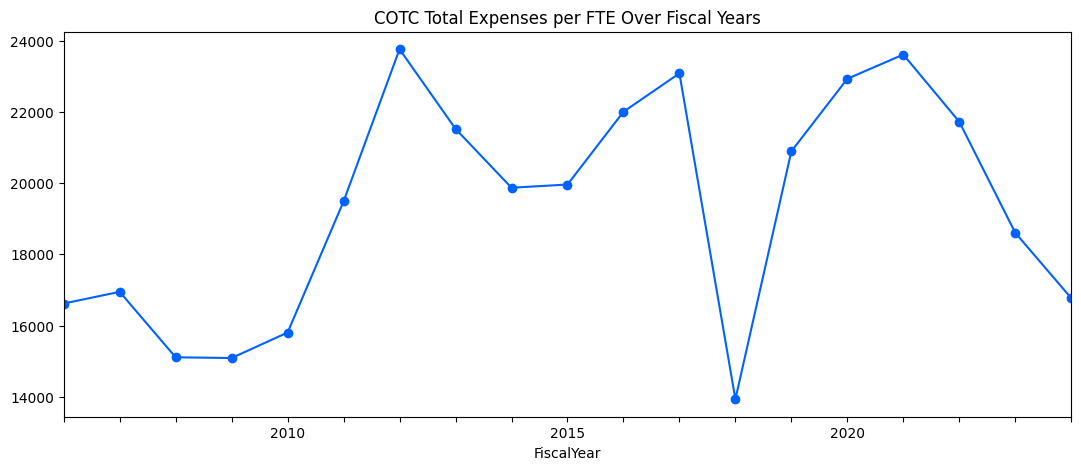

In [13]:
# Create the filtered DataFrame
COTC = df_time_series_finals[df_time_series_finals['UnitID'] == 201672].head(20).sort_values('FiscalYear')

# Call .plot() DIRECTLY on the COTC object
COTC['Total_Exp'].plot(
    y='Total_Exp', 
    marker='o', 
    xticks=COTC.index, 
    figsize=plotsize, 
    title='COTC Total Expenses per FTE Over Fiscal Years'
)

## More Investigation on Total Expense Data:

### Autocorrelation (ACF) and Partial Autocorrelation (PACF) analyses:

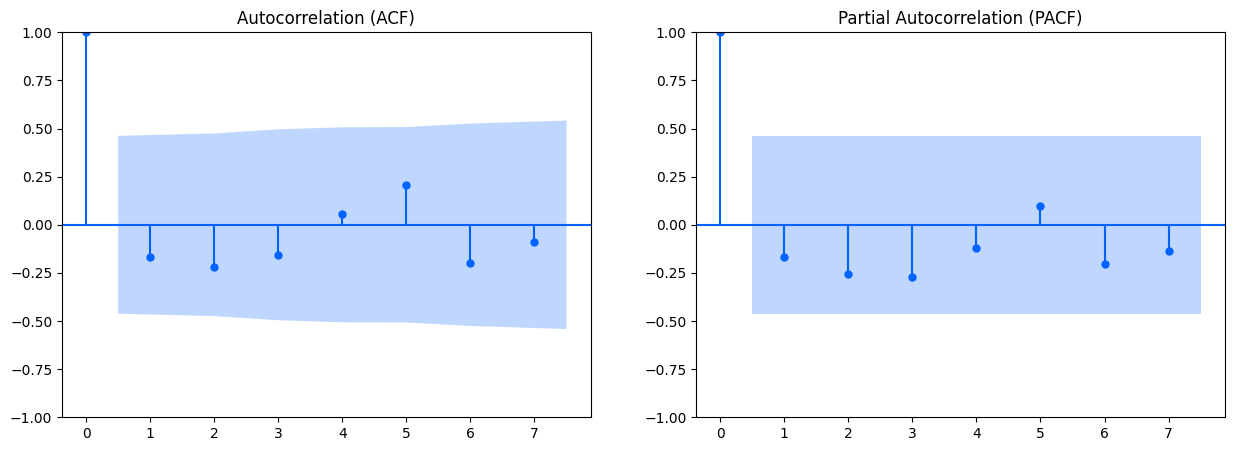

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

COTC = df_time_series_finals[df_time_series_finals['UnitID'] == 201672].head(20).sort_values('FiscalYear')
# Differencing the data (to remove the trend)
# df['Expenses'] is your original 19-year series
df_diff = COTC['Total_Exp'].diff().dropna()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF helps determine the 'q' (Moving Average) term
plot_acf(df_diff, lags=7, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')

# PACF helps determine the 'p' (Auto-Regressive) term
plot_pacf(df_diff, lags=7, ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.show()

### Augmented Dickey-Fuller (ADF) test:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

COTC_sorted = COTC.sort_values('FiscalYear')

# Extract and reset the index so it's a clean "stack" of numbers
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)

# Create the Date Index (now it matches the sorted numbers)
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values}, index=years)

# Check for Stationarity (ADF Test)
def check_stationarity(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    if result[1] <= 0.05:
        print("Result: Data is stationary")
    else:
        print("Result: Data is non-stationary (Needs differencing)")

print("--- Initial Data Check ---")
check_stationarity(df['Expenses'])

--- Initial Data Check ---
ADF Statistic: -2.364
p-value: 0.152
Result: Data is non-stationary (Needs differencing)


In [43]:
print(COTC_sorted)

            UnitID   FTE  Total_Exp
FiscalYear                         
2006        201672  1954 16618.4559
2007        201672  2012 16946.6365
2008        201672  2384 15106.5609
2009        201672  2930 15086.5286
2010        201672  3003 15803.5173
2011        201672  2673 19488.8329
2012        201672  2010 23763.3418
2013        201672  1886 21525.7173
2014        201672  1929 19871.6294
2015        201672  1841 19961.6293
2016        201672  1605 22005.9480
2017        201672  1628 23085.5081
2018        201672  1644 13928.9875
2019        201672  1614 20894.6766
2020        201672  1414 22932.6592
2021        201672  1207 23613.4042
2022        201672  1326 21725.1573
2023        201672  1482 18606.2555
2024        201672  1663 16770.0854


## Time Series Modeling and Forecasting:
### ARIMA:
#### (1,1,0)

Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:               Expenses   No. Observations:                   19
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -171.591
Date:                Thu, 22 Jan 2026   AIC                            347.182
Time:                        09:55:29   BIC                            348.962
Sample:                    06-30-2006   HQIC                           347.427
                         - 06-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0657      0.190     -0.347      0.729      -0.437       0.306
sigma2      1.158e+07   3.57e+06      3.245      0.001    4.58e+06    1.86e+07
Ljung-Box (L1) (Q):      

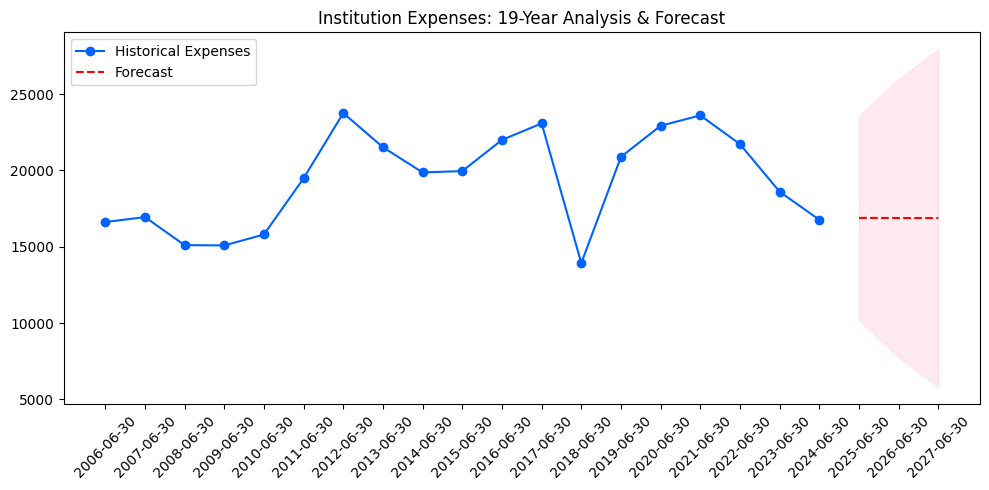

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Sort by the original FiscalYear column FIRST
# This ensures 2006 is at the top and 2024 is at the bottom
COTC_sorted = COTC.sort_values('FiscalYear')

# Extract and reset the index so it's a clean "stack" of numbers
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)

# Create the Date Index (now it matches the sorted numbers)
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values}, index=years)

# Run the model
model = ARIMA(df['Expenses'], order=(1, 1, 0), missing='drop')
model_fit = model.fit()

print("Model fitted successfully!")
print(model_fit.summary())


# Forecast
forecast_steps = 3
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()


print("\n--- Forecast for Next 3 Years ---")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])
# Plotting (Convert index to string to prevent Matplotlib formatting glitches)
plt.figure(figsize=(10, 5))
plt.plot(df.index.astype(str), df['Expenses'], label='Historical Expenses', marker='o')

# Create labels for the forecast dates
forecast_labels = forecast_df.index.astype(str)
plt.plot(forecast_labels, forecast_df['mean'], label='Forecast', color='red', linestyle='--')

plt.fill_between(forecast_labels, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], color='pink', alpha=0.3)

plt.title('Institution Expenses: 19-Year Analysis & Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#COTC['Total_Exp'].isnull().sum()

### ARIMA:
#### (0,1,1)

Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:               Expenses   No. Observations:                   19
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -171.651
Date:                Thu, 22 Jan 2026   AIC                            347.302
Time:                        09:56:28   BIC                            349.083
Sample:                    06-30-2006   HQIC                           347.548
                         - 06-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1063      0.212     -0.501      0.616      -0.522       0.310
sigma2      1.307e+07   4.59e+06      2.846      0.004    4.07e+06    2.21e+07
Ljung-Box (L1) (Q):      

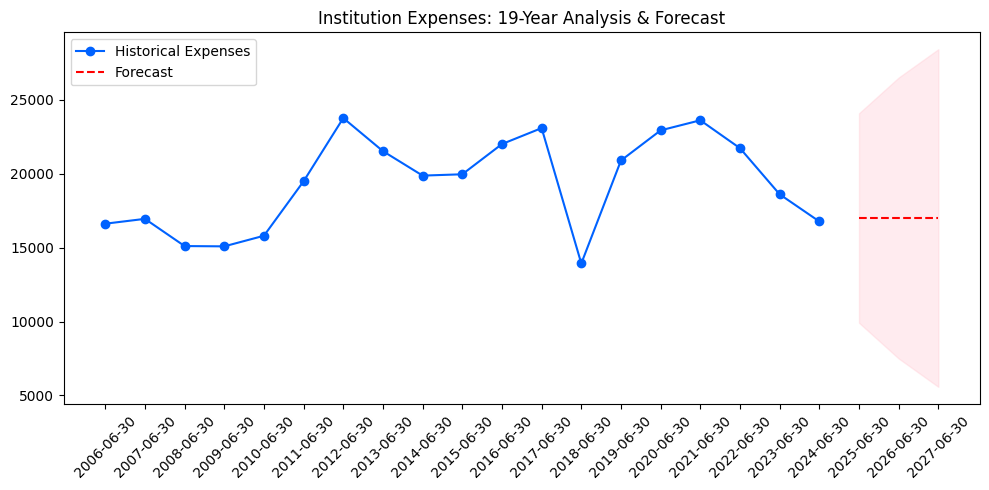

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

COTC_sorted = COTC.sort_values('FiscalYear')

# Extract and reset the index so it's a clean "stack" of numbers
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)

# Create the Date Index (now it matches the sorted numbers)
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values}, index=years)

# Run the model
# Even if data looks clean, 'missing=drop' prevents crashes from invisible data issues
# d=1 for differencing as our data was non-stationary (p, d, q)
model = ARIMA(df['Expenses'], order=(0, 1, 1), missing='drop')
model_fit = model.fit()

print("Model fitted successfully!")
print(model_fit.summary())


# Forecast the next 3 years
forecast_steps = 3
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

print("\n--- Forecast for Next 3 Years ---")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])
# Plotting (Convert index to string to prevent Matplotlib formatting glitches)
plt.figure(figsize=(10, 5))
plt.plot(df.index.astype(str), df['Expenses'], label='Historical Expenses', marker='o')

# Create labels for the forecast dates
forecast_labels = forecast_df.index.astype(str)
plt.plot(forecast_labels, forecast_df['mean'], label='Forecast', color='red', linestyle='--')

plt.fill_between(forecast_labels, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], color='pink', alpha=0.3)

plt.title('Institution Expenses: 19-Year Analysis & Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Differencing:

New p-value after manual differencing: 0.041


<Axes: title={'center': 'Year-over-Year Change (Stationary Data)'}, xlabel='FiscalYear'>

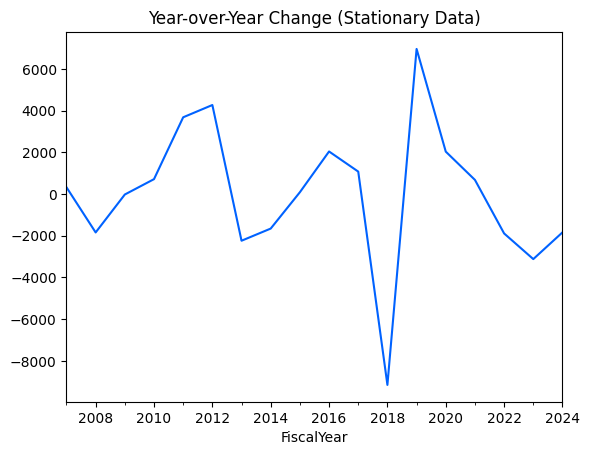

In [19]:
# Create the differenced data
COTC_sorted = COTC.sort_values('FiscalYear')
# SELECT THE COLUMN FIRST to make it 1D, then difference
# Using ['Total_Exp'] turns the 2D DataFrame into a 1D Series
df_stationary = COTC_sorted['Total_Exp'].diff().dropna()

# Check stationarity again on the NEW data
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_stationary)
print(f'New p-value after manual differencing: {result[1]:.3f}')

# Plot it to see it "flatten out"
df_stationary.plot(title="Year-over-Year Change (Stationary Data)")

### As p-value is now below 0.05, it means differencing was successful and $d=1$ choice for the ARIMA model is scientifically justified.

### Residual plot:

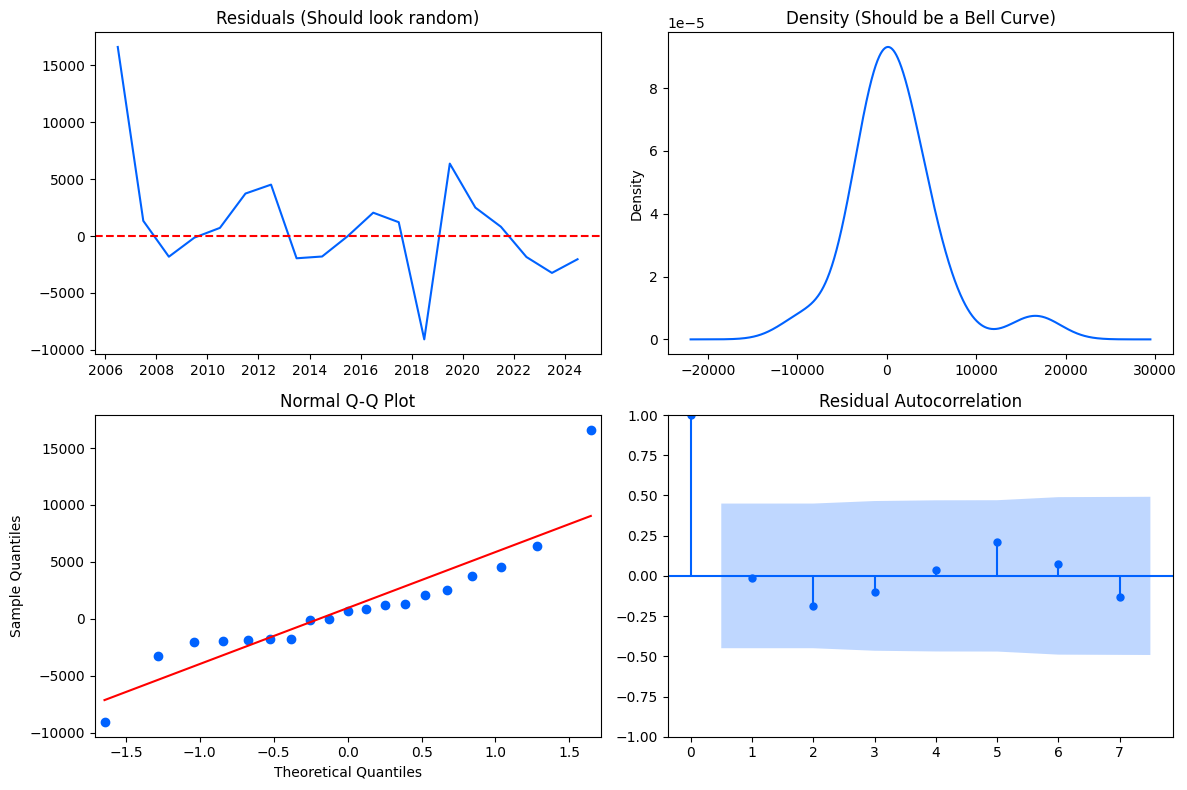

--- Ljung-Box Test Results ---
   lb_stat  lb_pvalue
7   3.1721     0.8686


In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
COTC_sorted = COTC.sort_values('FiscalYear')

# Extract and reset the index so it's a clean "stack" of numbers
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)

# Create the Date Index (now it matches the sorted numbers)
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values}, index=years)

# Run the model
model = ARIMA(df['Expenses'], order=(1, 1, 0), missing='drop')
model_fit = model.fit()

# Extract the residuals
residuals = model_fit.resid

# Create a diagnostic dashboard
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot: Standardized Residuals
# Look for: A random "zig-zag" around 0. No trends or cycles.
axes[0, 0].plot(residuals)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals (Should look random)')

# Plot: Histogram/KDE
# Look for: A "Bell Curve" (Normal Distribution).
residuals.plot(kind='kde', ax=axes[0, 1], title='Density (Should be a Bell Curve)')

# Plot: Q-Q Plot
# Look for: The blue dots should follow the red line closely.
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')

# Plot: ACF of Residuals
# Look for: All bars (except lag 0) should be inside the blue area.
sm.graphics.tsa.plot_acf(residuals, lags=7, ax=axes[1, 1])
axes[1, 1].set_title('Residual Autocorrelation')

plt.tight_layout()
plt.savefig('Time_Series_Residual_plot.png', dpi=300)
plt.show()

# Statistical Test: Ljung-Box
# This formally tests if the residuals are independent (noise).
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[7], return_df=True)
print("--- Ljung-Box Test Results ---")
print(lb_test)

# Time Series Cross-Validation

### ARIMA
#### (1,1,0)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Setup parameters
data = COTC['Total_Exp']
n_total = len(data)
min_train_size = 15  # Start training with 15 years, test on remaining 4
predictions = []
actuals = []

print("--- Starting Walk-Forward Cross-Validation ---")

# Walk-forward loop
for i in range(min_train_size, n_total):
    # Split data
    train = data.iloc[:i]
    test = data.iloc[i]
    
    # Fit model on training set
    cv_model = ARIMA(train, order=(1, 1, 0))
    cv_fit = cv_model.fit()
    
    # Forecast 1 step ahead
    pred = cv_fit.forecast(steps=1).iloc[0]
    
    # Store results
    predictions.append(pred)
    actuals.append(test)
    
    print(f"Year {data.index[i].year}: Actual={test:.2f}, Predicted={pred:.2f}")

# Calculate Error Metrics
mae = mean_absolute_error(actuals, predictions)
mape = mean_absolute_percentage_error(actuals, predictions) * 100

print("\n--- Validation Results ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Interpret the Accuracy
print(f"\nOn average, this model's predictions are off by {mape:.2f}%.")
if mape < 5:
    print("Interpretation: Highly Accurate")
elif mape < 10:
    print("Interpretation: Good Accuracy")
else:
    print("Interpretation: Caution - High Variance")

--- Starting Walk-Forward Cross-Validation ---
Year 2021: Actual=23613.40, Predicted=22738.36
Year 2022: Actual=21725.16, Predicted=23550.98
Year 2023: Actual=18606.26, Predicted=21904.70
Year 2024: Actual=16770.09, Predicted=18857.16

--- Validation Results ---
Mean Absolute Error (MAE): 2021.60
Mean Absolute Percentage Error (MAPE): 10.57%

On average, this model's predictions are off by 10.57%.
Interpretation: Caution - High Variance


### ARIMA
#### (0,1,1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Setup parameters
data = COTC['Total_Exp']
n_total = len(data)
min_train_size = 15  # Start training with 15 years, test on remaining 4
predictions = []
actuals = []

print("--- Starting Walk-Forward Cross-Validation ---")

# Walk-forward loop
for i in range(min_train_size, n_total):
    # Split data
    train = data.iloc[:i]
    test = data.iloc[i]
    
    # Fit model on training set
    cv_model = ARIMA(train, order=(0, 1, 1))
    cv_fit = cv_model.fit()
    
    # Forecast 1 step ahead
    pred = cv_fit.forecast(steps=1).iloc[0]
    
    # Store results
    predictions.append(pred)
    actuals.append(test)
    
    print(f"Year {data.index[i].year}: Actual={test:.2f}, Predicted={pred:.2f}")

# Calculate Error Metrics
mae = mean_absolute_error(actuals, predictions)
mape = mean_absolute_percentage_error(actuals, predictions) * 100

print("\n--- Validation Results ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Interpret the Accuracy
print(f"\nOn average, this model's predictions are off by {mape:.2f}%.")
if mape < 5:
    print("Interpretation: Highly Accurate")
elif mape < 10:
    print("Interpretation: Good Accuracy")
else:
    print("Interpretation: Caution - High Variance")

--- Starting Walk-Forward Cross-Validation ---
Year 2021: Actual=23613.40, Predicted=22435.90
Year 2022: Actual=21725.16, Predicted=23440.28
Year 2023: Actual=18606.26, Predicted=22010.01
Year 2024: Actual=16770.09, Predicted=19082.25

--- Validation Results ---
Mean Absolute Error (MAE): 2152.14
Mean Absolute Percentage Error (MAPE): 11.24%

On average, this model's predictions are off by 11.24%.
Interpretation: Caution - High Variance


### The ARIMA model of (1,1,0) has lower mape, thereby it will be our choice for furthure analysis:
#### MAPE is high (over 10%): the data has high year-to-year volatility

In financial forecasting, an error around 10% usually indicates that while the overall trend is clear, the year-to-year "jumps" (volatility) are large enough that a single point-estimate isn't enough.

# ARIMAX model (ARIMA with FTE as eXogenous variables)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Sort and Clean Data
COTC_sorted = COTC.sort_values('FiscalYear')
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)
exog_historical = COTC_sorted['FTE'].reset_index(drop=True)

# Create the Date Index
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values, 'FTE': exog_historical.values}, index=years)

# Fit the ARIMAX Model
model = ARIMA(df['Expenses'], 
              exog=df['FTE'], 
              order=(1, 1, 0))
model_fit = model.fit()
print("Model fitted successfully!")
print(model_fit.summary())

# Define Future Enrollment
future_fte_values = [1500, 1400, 1300] 

# Convert to 2D array or DataFrame so ARIMA recognizes it as 'exog'
future_exog = pd.DataFrame({'FTE': future_fte_values}, 
                           index=pd.date_range(start=years[-1] + pd.offsets.YearEnd(), 
                                               periods=3, freq='A-JUN'))

# Forecast
forecast = model_fit.get_forecast(steps=3, exog=future_exog)
forecast_df = forecast.summary_frame()

print("\n--- Forecast with Enrollment (ARIMAX) ---")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])

Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:               Expenses   No. Observations:                   19
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -169.692
Date:                Thu, 22 Jan 2026   AIC                            345.383
Time:                        10:05:50   BIC                            348.054
Sample:                    06-30-2006   HQIC                           345.751
                         - 06-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FTE           -5.4181      4.347     -1.246      0.213     -13.938       3.102
ar.L1         -0.0460      0.137     -0.336      0.737      -0.314       0.222
sigma2      8.709e+06   2

Here is the breakdown to show the addition of FTE (Full-Time Equivalent) enrollment helped:

1. AIC Comparison: Without FTE: 347.182 With FTE: 345.383 
The AIC decreased by 1.799. In statistics, a lower AIC means a better model, providing enough useful information to justify its inclusion.

2. The Significance ($P > |z|$) FTE ($P = 0.213$): This is not "statistically significant" at the standard $0.05$ level. This means there is about a 21% chance that the relationship between FTE and Expenses you are seeing is just due to random noise. 
Comparison: However, $0.213$ is much "stronger" than your AR(1) term ($0.737$). This suggests that enrollment is a better predictor of the costs than last year's costs were.

3. Residual Health (Ljung-Box) With FTE: $1.51$ Without FTE: $0.34$ 
Both values are well above the critical threshold, we look for the Prob(Q) statistic which is still above 0.05. The errors are still "White Noise," meaning the model isn't "broken" by adding the extra variable.  

Did it "Help"? Yes, but marginally. The model is now more "intelligent" because it accounts for the fact that expenses change when the student population changes. Even though it didn't hit the "magic" $0.05$ significance level, the drop in AIC tells us that the ARIMAX model is a slightly better representation of reality than the simple ARIMA model.

Correlation exists: There is a moderate relationship between enrollment and cost-per-student, but it isn't the only thing driving costs (which makes sense, as faculty salaries and facilities costs are often fixed). Increased Complexity is Justified: Since both the AIC, and BIC dropped. 

# ARIMAX (ARIMA with eXogenous variables) - Forecasing graph:

                               SARIMAX Results                                
Dep. Variable:               Expenses   No. Observations:                   19
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -169.692
Date:                Thu, 22 Jan 2026   AIC                            345.383
Time:                        10:20:20   BIC                            348.054
Sample:                    06-30-2006   HQIC                           345.751
                         - 06-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FTE           -5.4181      4.347     -1.246      0.213     -13.938       3.102
ar.L1         -0.0460      0.137     -0.336      0.737      -0.314       0.222
sigma2      8.709e+06   2.09e+06      4.173      0.0

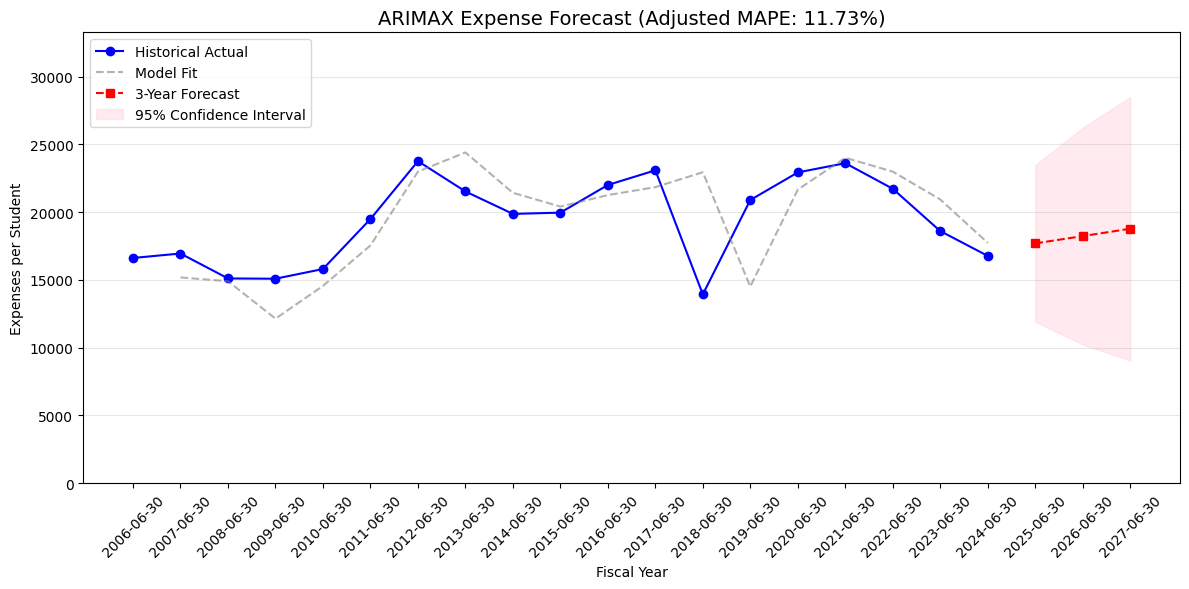


--- ARIMAX Forecast Results ---
             Forecast  Lower Bound  Upper Bound
2025-06-30 17692.5500   11908.5900   23476.5000
2026-06-30 18232.5500   10238.5200   26226.5700
2027-06-30 18774.4400    9053.8600   28495.0200


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Sort and Clean Data
COTC_sorted = COTC.sort_values('FiscalYear')
expenses_clean = COTC_sorted['Total_Exp'].reset_index(drop=True)
exog_historical = COTC_sorted['FTE'].reset_index(drop=True)

# Create the Date Index
years = pd.date_range(start='2006', periods=len(expenses_clean), freq='A-JUN')

# Create the DataFrame
df = pd.DataFrame({'Expenses': expenses_clean.values, 'FTE': exog_historical.values}, index=years)

# Fit the ARIMAX Model
model = ARIMA(df['Expenses'], exog=df['FTE'], order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


historical_predictions = model_fit.fittedvalues
mape = mean_absolute_percentage_error(df['Expenses'][1:], historical_predictions[1:]) * 100

print(f"Model Fitted Successfully!")
print(f"Adjusted In-Sample MAPE: {mape:.2f}%")

# Define Future Enrollment
future_fte_values = [1500, 1400, 1300] 
future_dates = pd.date_range(start=years[-1] + pd.offsets.DateOffset(years=1), periods=3, freq='A-JUN')
future_exog = pd.DataFrame({'FTE': future_fte_values}, index=future_dates)

# Forecast
forecast = model_fit.get_forecast(steps=3, exog=future_exog)
forecast_df = forecast.summary_frame()

# Visualization
plt.figure(figsize=(12, 6))

# Plot Historical Actuals
plt.plot(df.index, df['Expenses'], label='Historical Actual', color='blue', marker='o')

# Plot Model Fit (Slicing [1:] to remove the negative dip)
plt.plot(df.index[1:], historical_predictions[1:], 
         label='Model Fit', color='gray', linestyle='--', alpha=0.6)

# Plot Forecast
plt.plot(forecast_df.index, forecast_df['mean'], label='3-Year Forecast', color='red', marker='s', linestyle='--')

# Plot Confidence Interval
plt.fill_between(forecast_df.index, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')


# Combine historical dates and forecast dates into one single index
full_date_range = df.index.append(forecast_df.index)

# Force Matplotlib to use every date in that range as a tick
plt.xticks(full_date_range, [d.strftime('%Y-%m-%d') for d in full_date_range], rotation=45)

# Force Y-axis to start at 0
plt.ylim(0, df['Expenses'].max() * 1.4) 

plt.title(f'ARIMAX Expense Forecast (Adjusted MAPE: {mape:.2f}%)', fontsize=14)
plt.ylabel("Expenses per Student")
plt.xlabel("Fiscal Year")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout() 
plt.savefig('ARIMAX_Expense_Forecast.png', dpi=300)
plt.show()

# Summary output
print("\n--- ARIMAX Forecast Results ---")
# Extract only the necessary columns from the forecast_df
final_table = forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].copy()
final_table.columns = ['Forecast', 'Lower Bound', 'Upper Bound']
print(final_table.round(2))

# Holt Exponential Smoothing:

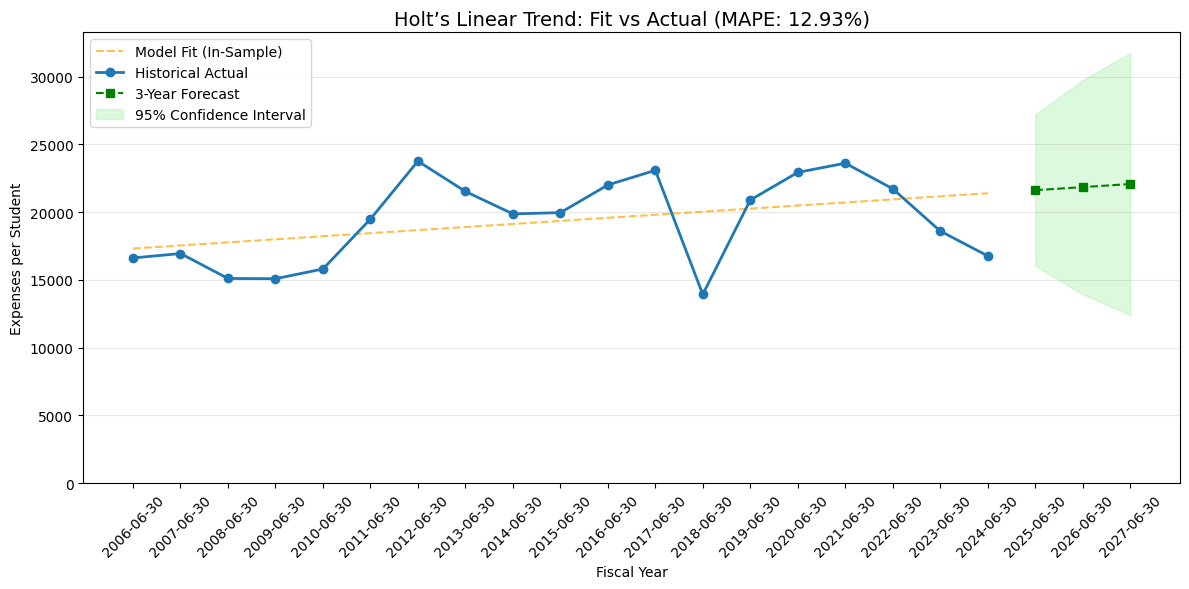

--- Holt’s Forecast Results ---
             Forecast  Lower Bound  Upper Bound
2025-06-30 21620.2000   16035.5100   27204.9000
2026-06-30 21846.7800   13948.8300   29744.7300
2027-06-30 22073.3500   12400.3800   31746.3300


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

# Data preparation
COTC_sorted = COTC.sort_values('FiscalYear')
series = COTC_sorted['Total_Exp'].astype(float).reset_index(drop=True)
years = pd.date_range(start='2006', periods=len(series), freq='A-JUN')
series.index = years

# Fit the model
model_holt = ExponentialSmoothing(series, trend='add', seasonal=None)
model_fit = model_holt.fit()

# Forecast
forecast_steps = 3
forecast_values = model_fit.forecast(forecast_steps)

# Calculate confidence interval
residuals = model_fit.resid
std_error = np.std(residuals)
steps_out = np.arange(1, forecast_steps + 1)
margin = 1.96 * std_error * np.sqrt(steps_out)
ci_upper = forecast_values + margin
ci_lower = forecast_values - margin

# Visualization
plt.figure(figsize=(12, 6))

# This shows how well the model learned the past
plt.plot(series.index.astype(str), model_fit.fittedvalues, 
         label='Model Fit (In-Sample)', color='orange', linestyle='--', alpha=0.7)

# Plot Historical Actuals
plt.plot(series.index.astype(str), series, 
         label='Historical Actual', marker='o', color='#1f77b4', linewidth=2)

# Plot Forecast
forecast_index_str = forecast_values.index.astype(str)
plt.plot(forecast_index_str, forecast_values, 
         label='3-Year Forecast', color='green', linestyle='--', marker='s')

# Fill Confidence Interval
plt.fill_between(forecast_index_str, ci_lower, ci_upper, 
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')
                 
plt.ylim(0, df['Expenses'].max() * 1.4) 
plt.title(f"Holt’s Linear Trend: Fit vs Actual (MAPE: {mean_absolute_percentage_error(series, model_fit.fittedvalues)*100:.2f}%)", fontsize=14)
plt.ylabel("Expenses per Student")
plt.xlabel("Fiscal Year")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('Holt’s_Linear_Trend_Forecast.png', dpi=300)
plt.show()

# Summary output
print("--- Holt’s Forecast Results ---")
df_res = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower Bound': ci_lower,
    'Upper Bound': ci_upper
})
print(df_res.round(2))

ARIMAX vs. Holt:
1. The MAPE (Accuracy) Lower is better. If the ARIMAX MAPE is $11.73\%$ and Holt’s is $12.93\%$, it proves that including the FTE enrollment data actually helped the model understand the history better. 

2. The Forecast "Direction" Holt’s will almost always project a straight line based on the past trend. ARIMAX will "bend" based on the future FTE values. The ARIMAX forecast per student will spike up If there is sudden drop in FTE, this considered as a "Risk-Adjusted" view that Holt’s simply cannot see.

We can use the Holt's forecast as a "Business as Usual" scenario and the ARIMAX as an "Enrollment-Driven" scenario.